# <p style="text-align: center;">MIS 382N: Advanced Predictive Modeling</p>
# <p style="text-align: center;">Assignment 2</p>
## <p style="text-align: center;">Total points: 60</p>
## <p style="text-align: center;">Due: Wed, October 05, by 11:59pm</p>


Your homework should be written in a **Jupyter notebook** (except for Q6). Please submit **only one** ipynb file from each group, and include the names of all the group members in your ipynb file. Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting.

In [72]:
import math
import pandas as pd
import numpy as np
%pylab inline
import seaborn
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn import linear_model
from sklearn.metrics import make_scorer

Populating the interactive namespace from numpy and matplotlib


---

# Question 1: Sampling (6 pts)

A recent survey estimated that $30\%$ of all Europeans aged 20 to 22 have driven under the influence of drugs or alcohol, based on a simple "Yes or No" question. A similar survey is being planned for Americans. The survey designers want the  $90\%$ confidence interval to have a margin of error of at most $\pm0.09$.

(a) Find the necessary sample size needed to conduct this survey assuming that the expected percentage of "yes" answers will be very close to that obtained from the European survey? (2 pts)

(b) Suppose the tolerance level was kept the same but the confidence level needs to increase to $95\%$. What is the required sample size for this new specification? (2 pts)

(c) If one does not know where the true "$p$" may lie, one can conservatively conduct a survey assuming the worst case (in terms of required minimum sample size)  scenario of  $p = 0.5$. Redo part (b) for this "worst case" scenario. (2 pts)

## (a)

The equation to determine the number of samples required is:

$$ n \geq \hat{p} * (1 - \hat{p}) * (\frac{Z_{\alpha/2}}{\epsilon})^2 $$

where $n$ is the minimum sample size required to achieve the desired confidence interval and margin of error, $\hat{p}$ is the expected number of "Yes" responses, $Z_{\alpha/2}$ is the critical value assuming a normal distribution, and $\epsilon$ is the margin of error. In this case: 

$$\hat{p} = 0.3$$
$$Z_{\alpha/2} = 1.65$$ 
$$\epsilon = 0.09$$

$Z_{\alpha/2}$ is 1.65 because 90% of the probability is within $+/-$ 1.65 $\sigma$ of the mean. This number changes based on the desired confidence interval.

In [3]:
def MinSample(phat, conf_int, epsilon):
    '''Returns the minimum sample size required to achieve a desired confidence level and margin of error with a known expected
    p value'''
    if conf_int == 0.9:
        Z = 1.65
    elif conf_int == 0.95:
        Z = 1.96
    elif conf_int == 0.99:
        Z = 2.58
    n_min = phat*(1-phat)*(Z/epsilon)**2
    return math.ceil(n_min)

phat = 0.3
conf_int = 0.9
epsilon = 0.09

print 'The minimum sample required to achieve a confidence interval of %.2f and a margin of error of %.2f is %i.' % (conf_int, epsilon, 
                                                                                                                  MinSample(phat, conf_int, epsilon))

The minimum sample required to achieve a confidence interval of 0.90 and a margin of error of 0.09 is 71.


## (b)
If the confidence interval is raised to 95%, then the only parameter that changes is $Z_{\alpha/2}$, which is now equal to 1.96 because 95% of the probability is within $+/-$ 1.96 $\sigma$ of the mean.

In [4]:
conf_int = 0.95
print 'The minimum sample required to achieve a confidence interval of %.2f and a margin of error of %.2f is %i.' % (conf_int, epsilon, 
                                                                                                                   MinSample(phat, conf_int, epsilon))

The minimum sample required to achieve a confidence interval of 0.95 and a margin of error of 0.09 is 100.


## (c)

In [5]:
phat = 0.5
print 'The minimum sample required to achieve a confidence interval of %.2f and a margin of error of %.2f is %i.' % (conf_int, epsilon, 
                                                                                                                   MinSample(phat, conf_int, epsilon))

The minimum sample required to achieve a confidence interval of 0.95 and a margin of error of 0.09 is 119.


---

# Question 2 (2+2 = 4 points)

View the video at:

https://www.youtube.com/watch?v=jbkSRLYSojo

(Hans Rosling's 200 Countries, 200 Years, 4 Minutes) and answer the following questions:

1. How many variables are being visualized in the “moving bubble plots” video (list them)?

2. Identify a variable that is “zoomed into”, i.e., examined at a sub-category or more detailed level.


FACTOID: Rosling’s gapminder visualization

(see https://www.youtube.com/user/Gapcast for some more insightful videos) can now be

readily used by you via Google Charts: https://developers.google.com/chart/interactive/docs/gallery

Just plug in your own variables into “Bubble Chart” under the URL above and go!

## 1.

There are 6 variables being visualized in the "moving bubble plots":
1. Country
2. Region/Continent
2. Income per Person
3. Life Expectancy
4. Population
5. Year

## 2. 
The variable "Country" is "zoomed into" as he examines provinces within China. Upon examining a few sub-categories (provinces), he is able to see that the province Shanghai has similar wealth and health to Italy today, while the province Guizou is comparable to Pakistan. By splitting Guizou further, he can see that the rural parts have wealth and health similar to Ghana.

---

# Question 3: Principal Component Analysis (PCA) (10 pts)

Download the US imports dataset from Canvas, or from [here](https://www.census.gov/foreign-trade/statistics/product/enduse/imports/enduse_imports.xlsx).

This code will clean the data and format it so that it is PCA-ready:

In [6]:
import pandas as pd

df = pd.read_excel('enduse_imports.xlsx')

# gather columns we care about
df = df.loc[:,['CTY_DESC','COMM_DESC','value_15']]
df.columns = pd.Series(['Country','Good','Value'])

# not a country, remove
df = df[df['Country'] != 'World Total']

# some countries had imports recorded twice
# remove these countries for simplicity
importCount = df.groupby(['Country','Good']).count().iloc[:,0]
duplicatedImports = importCount[importCount > 1]
countriesWithDuplicates = duplicatedImports.index.get_level_values(0).unique()
print "duplicated countries: "
print [str(country) for country in countriesWithDuplicates]
df = df[df['Country'].isin(countriesWithDuplicates) == False]

# remove countries that don't export
totalImports = df[['Country','Value']].groupby('Country').sum().iloc[:,0]
countriesWithNoImport = totalImports[totalImports == 0].index
print "countries that don't trade with USA: "
print [str(country) for country in countriesWithNoImport]
df = df[df['Country'].isin(countriesWithNoImport) == False]

# reshape so that each type of good has its own column
df = df.pivot(index='Country',columns='Good',values='Value')
df = df.fillna(0)

# import PCA
from sklearn.decomposition import PCA

duplicated countries: 
['Montenegro', 'Serbia', 'Sudan']
countries that don't trade with USA: 
['Cuba', 'Korea, North', 'Netherlands Antilles']


In [7]:
df.iloc[:5,:5] # display first five rows and columns

Good,"Agricultural machinery, equipment","Alcoholic beverages, excluding wine","Apparel, household goods - cotton","Apparel, household goods - wool","Apparel, textiles, nonwool or cotton"
Country,,,,,
Afghanistan,3105.0,0.0,10739.0,7314.0,11942.0
Albania,0.0,34741.0,2752171.0,50838.0,1298224.0
Algeria,0.0,0.0,0.0,0.0,0.0
Andorra,0.0,0.0,351.0,0.0,0.0
Angola,0.0,24505.0,0.0,0.0,0.0


Now gather the top two principal components from this dataset and  
(a) Make a scatter plot with the first component as the x-axis and the second as the y-axis. (3 pts)

(b) Find the names of the six countries with the highest first component (these should be clear outliers). (2 pts)

(c) Given the results of parts (a) and (b), one might theorize that the first component roughly represents the total volume of exports to the US.  Using the components\_ attribute, gather the loadings of the first component.  Also use the original dataframe to gather the total imports to the US for each good.  Divide this list of total imports per good by the total US imports period, so that for each good we know what percent of imports it accounted for.  Make a scatter plot with this value on the x-axis and the first component's loadings on the right. (3 pts)

(d) For the four goods with the highest component loadings, print the name of the good and the percent of imports it accounts for.  Briefly comment on whether you think the first component represents the total volume of imports, or whether it has another interpretation - no right or wrong answer. (2 pts)

## (a)

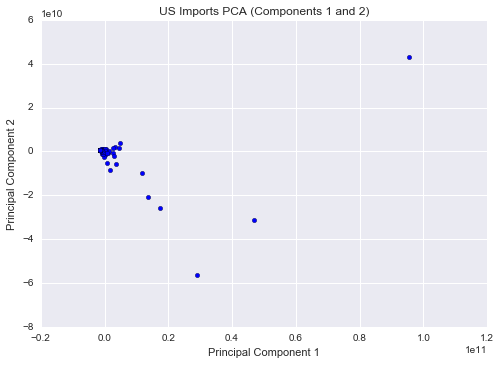

In [8]:
# Fit PCA to US Imports data to gather top two principal components
importsPCA = PCA(n_components=2)
importsPCA.fit(df)

df_transform = importsPCA.transform(df)

# Gather two principal components
PC1 = df_transform[:,0]
PC2 = df_transform[:,1]

# Plot first component (x-axis) vs. second component (y-axis)
scatter(PC1, PC2)
xlabel('Principal Component 1')
ylabel('Principal Component 2')
title('US Imports PCA (Components 1 and 2)')

## (b)

In [9]:
# Create dataframe with countries as index and each component as columns
df_pca = pd.DataFrame({'PC1': PC1, 'PC2': PC2}, index = df.index.values)

# Sort dataframe and get 6 countries with highest first component
top6_comp1 = df_pca.sort_values(by='PC1', ascending=False)[:6]
top6_comp1.drop('PC2', axis=1)

,PC1
China,9.550198e+10
Mexico,4.687003e+10
Canada,2.912037e+10
Japan,1.734897e+10
Germany,1.366577e+10
"Korea, South",1.169313e+10


In [10]:
pd.Series(top6_comp1['PC1'], index=top6_comp1.index.values)

China           9.550198e+10
Mexico          4.687003e+10
Canada          2.912037e+10
Japan           1.734897e+10
Germany         1.366577e+10
Korea, South    1.169313e+10
Name: PC1, dtype: float64

## (c)

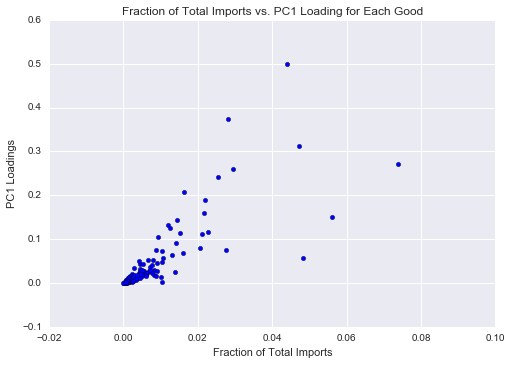

In [12]:
# Gather loadings of first component
PC1_loadings = importsPCA.components_[0]

# Gather total imports and fraction of national imports for each good 
imports_perGood = df.sum(axis=0)
totImports = sum(imports_perGood)
fracImports_perGood = imports_perGood/totImports

# Plot fraction of total imports vs. first component's loading for each good
scatter(fracImports_perGood, PC1_loadings)
xlabel('Fraction of Total Imports')
ylabel('PC1 Loadings')
title('Fraction of Total Imports vs. PC1 Loading for Each Good')

## (d)

In [151]:
# Four good with highest component 1 loadings
PC1_loadings = pd.Series(PC1_loadings, index=df.columns.values)
top4_loadings = PC1_loadings.sort_values(ascending=False)[:4]
top4_loadings

Cell phones and other household goods, n.e.c.    0.498743
Computers                                        0.373873
Other parts and accessories of vehicles          0.312492
Passenger cars, new and used                     0.270259
dtype: float64

In [148]:
# Four goods with highest component 1 loadings and fraction of imports they account for
top4_goods = top4_loadings.index.values
fracImports_perGood[top4_goods]

Good
Cell phones and other household goods, n.e.c.    0.043926
Computers                                        0.028141
Other parts and accessories of vehicles          0.047283
Passenger cars, new and used                     0.073866
dtype: float64

In [137]:
# Top 10 goods in terms of fraction of imports they account for
fracImports_perGood.sort_values(ascending=False)[:10]

Good
Passenger cars, new and used                     0.073866
Crude oil                                        0.055970
Pharmaceutical preparations                      0.048130
Other parts and accessories of vehicles          0.047283
Cell phones and other household goods, n.e.c.    0.043926
Telecommunications equipment                     0.029491
Computers                                        0.028141
U.S. goods returned, and reimports               0.027594
Computer accessories                             0.025344
Industrial machines, other                       0.022844
dtype: float64

### Comments:
While there does seem to be a correlation between total imports and first component loadings, the first component does not appear to solely represent the total volume of imports. The goods with the highest loadings do not directly align with the goods that have the highest fraction of imports. The two goods with the highest loadings are "Cell phones and other household goods" and "Computers". Both of these goods have significantly lower total imports than goods such as "Crude Oil" and "Pharmaceutical preparations", which both are not in the list of goods with the top 4 component 1 loadings. It seems that the first component is more aligned with the technology level of the good than with total imports.

---

# Question 4: Visualization using Bokeh (10 pts)

In this problem, you'll build an interactive visualization. Bokeh is a Python interactive visualization library that targets modern web browsers for presentation. For more information on Bokeh, see http://bokeh.pydata.org/en/latest/. The problem statement is as follows:

Using the [King County House Sales](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original) data, your goal is to build a Bokeh visualization which allows the user explore how price varies with living room size and year built. You will create a visualization that allows the user to toggle the X axis of a scatter plot between living room size and year built, with the y-axis always being price. Also add the hover tool so that if the user hovers over a datapoint in the living-room-size plot a window pops up that shows year built - and vice versa.

Hints: 
1. You can make use of Select widgets.
2. See: http://bokeh.pydata.org/en/latest/docs/user_guide/interaction.html#javascript-callbacks. Specifically look at the CustomJS for Widgets under Callbacks and the Select widget. 
3. see: http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#basic-tooltips for a hover tool example.
4. See: http://bokeh.pydata.org/en/latest/docs/reference/plotting.html. Look for the scatter API.
5. See: http://bokeh.pydata.org/en/0.10.0/docs/user_guide/styling.html#labels. For labeling axes.
6. Use output_notebook() from Bokeh to output the plot to your notebook

# Question 5: Ridge and Lasso Regression (6+6+4+4=20 points)

In this question, you will explore the application of Lasso and Ridge regression using sklearn package in Python. The dataset is Hitters.csv (available on canvas), which contains performance records and salaries for baseball players. More information on the data can be found [here](https://rdrr.io/cran/ISLR/man/Hitters.html). There are 17 variables: first 16 columns are performance related features and the last column is for Salary. We
wish to predict a baseball player’s Salary using all the 16 performance variables. Use a random state of 42 and a test size of 1/3 to [split the data into training and test](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html). Note: lambda is called alpha in sklearn.

1. Use sklearn.linear_model.Lasso and sklearn.linear_model.Ridge classes to do a [5-fold cross validation](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) using sklearn's [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html). For the sweep of the regularization parameter, we will look at a grid of values ranging from $\lambda = 10^{10}$ to $\lambda = 10^{-2}$. In Python, you can consider this range of values as follows:

    import numpy as np

    alphas =  10\***np.linspace(10,-2,100)*\*0.5

    Report the best chosen $\lambda$ based on cross validation. The cross validation should happen on your training data using  average MSE as the scoring metric.
2. Run ridge and lasso for all of the parameters specified above (on training data), and plot the coefficients learned for each of them - there should be one plot each for lasso and ridge, so a total of two plots; the plots for different features for a method should be on the same plot (e.g. Fig 6.6 of JW). What do you qualitatively observe when value of the regularization parameter is changed? 
3. Run least squares regression, ridge, and lasso on the training data. For ridge and lasso, use only the best regularization parameter. Report the prediction error (MSE) on the test data for each.
4. Run lasso again with cross validation using [sklearn.linear_model.LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Set the cross validation parameters as follows:

    LassoCV(alphas=None, cv=10, max_iter=10000)

    Report the best $\lambda$ based on cross validation. Run lasso on the training data using the best $\lambda$ and report the coefficeints for 16 variables. What do you observe from these coefficients?

In [22]:
hitters = pd.read_csv('Hitters.csv')
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


In [32]:
# Split data into training set (2/3) and test set (1/3)
train, test = train_test_split(hitters, test_size = 0.33, random_state = 42)
x_train = train.drop('Salary', axis=1)
y_train = train['Salary'].values
x_test = test.drop('Salary', axis=1)
y_test = test['Salary'].values

## 1.

In [119]:
# Set range of values for alpha(regularization paramater)
alphas = 10**np.linspace(10,-2,100)*0.5

# Initialize regression models
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()

# Set number of cross-validation folds
n_folds = 5

# Create empty lists to store mean-squared errors and standard deviations for each alpha value
lasso_scores = list()
lasso_std = list()
ridge_scores = list()
ridge_std = list()
# Fill lists with average mean-squared error for each cross validation
for alpha in alphas:
    lasso.alpha = alpha
    ridge.alpha = alpha
    lasso_score = cross_val_score(lasso, x_train, y_train, cv=n_folds, scoring='mean_squared_error')
    ridge_score = cross_val_score(ridge, x_train, y_train, cv=n_folds, scoring='mean_squared_error')
    lasso_scores.append(np.mean(lasso_score))
    lasso_std.append(np.std(lasso_score))
    ridge_scores.append(np.mean(ridge_score))
    ridge_std.append(np.std(ridge_score))

lasso_scores, lasso_std = np.array(lasso_scores)*-1, np.array(lasso_std)*-1
ridge_scores, ridge_std = np.array(ridge_scores)*-1, np.array(ridge_std)*-1

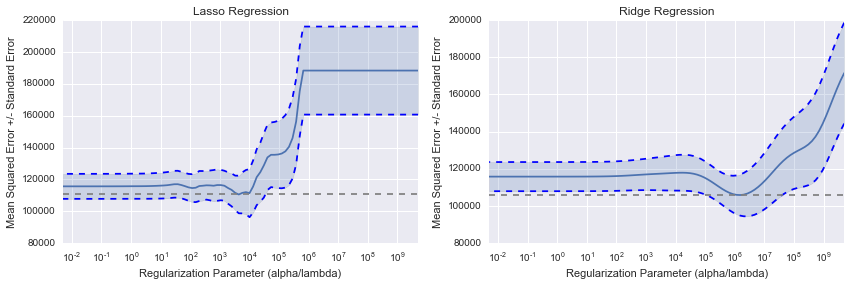

In [308]:
plt.figure(figsize=(14,4))

# Plot MSE vs. alpha for lasso regression
plt.subplot(121)
plt.semilogx(alphas, lasso_scores)
lasso_stdError = lasso_std / np.sqrt(n_folds)
plt.semilogx(alphas, lasso_scores + lasso_stdError, 'b--')
plt.semilogx(alphas, lasso_scores - lasso_stdError, 'b--')
plt.fill_between(alphas, lasso_scores + lasso_stdError, lasso_scores - lasso_stdError, alpha=0.2)
plt.axhline(np.min(lasso_scores), linestyle='--', color='.5')
plt.xlim([alphas[-1], alphas[0]])
xlabel('Regularization Parameter (alpha/lambda)')
ylabel('Mean Squared Error +/- Standard Error')
title('Lasso Regression')

# Plot MSE vs. alpha for ridge regression
plt.subplot(122)
plt.semilogx(alphas, ridge_scores)
ridge_stdError = ridge_std / np.sqrt(n_folds)
plt.semilogx(alphas, ridge_scores + ridge_stdError, 'b--')
plt.semilogx(alphas, ridge_scores - ridge_stdError, 'b--')
plt.fill_between(alphas, ridge_scores + ridge_stdError, ridge_scores - ridge_stdError, alpha=0.2)
plt.axhline(np.min(ridge_scores), linestyle='--', color='.5')
plt.xlim([alphas[-1], alphas[0]])
xlabel('Regularization Parameter (alpha/lambda)')
ylabel('Mean Squared Error +/- Standard Error')
title('Ridge Regression')

In [297]:
lasso_alpha = alphas[np.argmin(lasso_scores)]
ridge_alpha = alphas[np.argmin(ridge_scores)]
print 'Best Lambdas : '
print 'Lasso Regression :', lasso_alpha, '(10^%f)' % (math.log10(lasso_alpha))
print 'Ridge Regression :', ridge_alpha, '(10^%f)' % (math.log10(ridge_alpha))

Best Lambdas : 
Lasso Regression : 4348.74501309 (10^3.638364)
Ridge Regression : 1526927.75442 (10^6.183818)


## 2.

In [265]:
# Create empty data frame to store the coefficients for each value of alpha/lambda
df_coefs = pd.DataFrame(np.nan, index = alphas, columns = hitters.columns.values).drop('Salary', axis=1)

### Lasso Regression

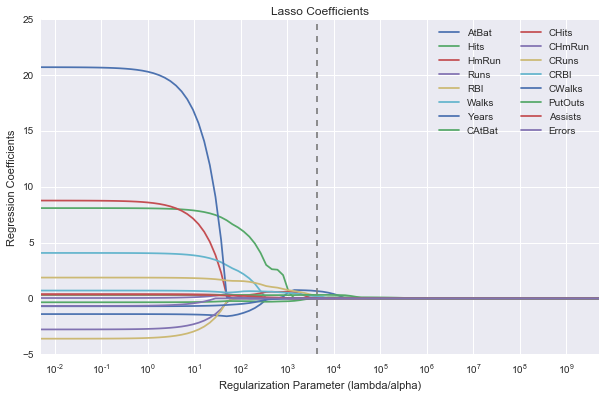

In [328]:
# Lasso Regression

## Initialize lasso model 
lasso = linear_model.Lasso()
## Initialize dataframe to store lasso coefficients
lasso_coefs = df_coefs
## Fill dataframe with regression coefficients for each value of alpha
for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(x_train, y_train)
    lasso_coefs.loc[alpha] = lasso.coef_

## Plot alpha vs. the value of each coefficients
plt.figure(figsize(10,6))
lasso_coefs.plot(logx=True)
legend(loc=1, ncol=2)
xlim([alphas[-1], alphas[0]])
title('Lasso Coefficients')
xlabel('Regularization Parameter (lambda/alpha)')
ylabel('Regression Coefficients')
## Indicate best regularization parameter
plt.axvline(lasso_alpha, linestyle='--', color='.5')

### Ridge Regression

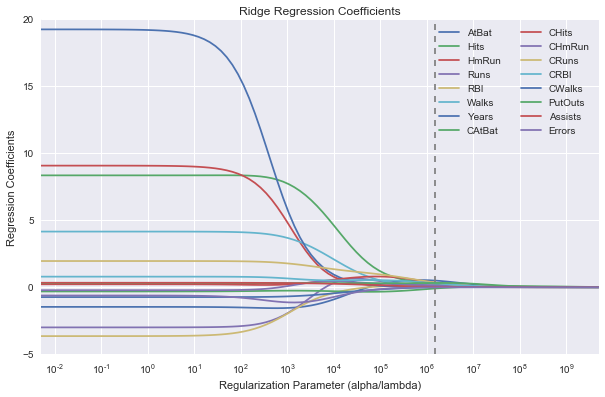

In [327]:
# Ridge Regression

## Initialize ridge model
ridge = linear_model.Ridge()
## Initialize dataframe to store ridge coefficients
ridge_coefs = df_coefs
## Fill dataframe with regression coefficients for each value of alpha
for alpha in alphas:
    ridge.alpha = alpha
    ridge.fit(x_train, y_train)
    ridge_coefs.loc[alpha] = ridge.coef_

## Plot alpha vs. the value of each coefficients
plt.figure(figsize(10,6))
ridge_coefs.plot(logx=True)
legend(loc=1, ncol=2)
xlim([alphas[-1], alphas[0]])
title('Ridge Regression Coefficients')
xlabel('Regularization Parameter (alpha/lambda)')
ylabel('Regression Coefficients')
## Indicate best regularization parameter
plt.axvline(ridge_alpha, linestyle='--', color='.5')

### Observations:

The ridge and lasso regressions have several similar attributes. At low values of the regularization parameter, regression coefficients are far from zero. At high values of the regularization parameter, all of the coefficients approach zero. The primary difference between the two approaches is that the coefficients appear to shrink toward zero sooner and quicker in the lasso regression than in the ridge regression. This means that at some values toward the middle of our regularization parameter spectrum, many coefficients that have been shrunk to zero (or close to zero) by the lasso regression are still fairly significant in the ridge regression

## 3.

In [318]:
# Least Squares
linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
linear_pred = linear.predict(x_test)
linear_MSE = np.mean((linear_pred - y_test)**2)

# Lasso
lasso = linear_model.Lasso(alpha = lasso_alpha)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)
lasso_MSE = np.mean((lasso_pred - y_test)**2)

# Ridge
ridge = linear_model.Ridge(alpha = ridge_alpha)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)
ridge_MSE = np.mean((ridge_pred - y_test)**2)

print 'Test Mean Squared Errors: '
print
print 'Linear Regression :', linear_MSE
print 'Lasso Regression  :', lasso_MSE
print 'Ridge Regression  :', ridge_MSE

Test Mean Squared Errors: 

Linear Regression : 159740.826016
Lasso Regression  : 171668.626512
Ridge Regression  : 164735.317126


## 4.

In [324]:
lassoCV = linear_model.LassoCV(alphas=None, cv=10, max_iter=10000)
lassoCV.fit(x_train, y_train)
lassoCV_pred = lassoCV.predict(x_test)
lassoCV_MSE = np.mean((lassoCV_pred - y_test)**2)

print 'Best Regularization Parameter (based on cross-validation):', lassoCV.alpha_, '(10^%f)' % math.log10(lassoCV.alpha_)

Best Regularization Parameter (based on cross-validation): 4311.12468383 (10^3.634591)


In [291]:
bestLasso_coefs = pd.Series(lassoCV.coef_, index = df_coefs.columns.values)
bestLasso_coefs

AtBat      0.654392
Hits       0.000000
HmRun      0.000000
Runs       0.000000
RBI        0.000000
Walks      0.000000
Years     -0.000000
CAtBat     0.000000
CHits      0.119242
CHmRun     0.000000
CRuns      0.206727
CRBI       0.206906
CWalks     0.000000
PutOuts    0.309638
Assists   -0.000000
Errors    -0.000000
dtype: float64

###  Observations:

The best regularization parameter based on the cross-validation results is approximately $10^{3.63}$. The corresponding lasso regression coefficients are shown above. When this shrinkage parameter is used, the majority of the coefficients are shrunk to zero (or very close to zero). In fact, only five coefficients remain significant: AtBat, CHits, CRuns, CRBI, and PutOuts.

# Question 6: Shiny app using R (10 points)

In this problem, you'll build a Shiny application. Shiny is an R
package which lets you publish web applications from R easily. For
more information on Shiny, see http://shiny.rstudio.com. The problem
statement is as follows:

We are going to use the "WorldPhones" dataset available in
"datasets" package. This dataset shows the number of
telephones (in thousands) in various regions of the world in
different years. The dataset will be loaded into a variable named
"WorldPhones" once you include the datasets
package (library(datasets)). Your goal is to build a Shiny
app which allows the user to visualize the distribution of the
number of telephones by region and by year (using bar graph). The
requirements are as follows:


1. You will give the user the option to choose between "Region" and
"Year". Use [check-box](http://shiny.rstudio.com/reference/shiny/latest/checkboxGroupInput.html) to get the user option. The default
option should be "Region".
2. You will also give the user the ability to choose between different regions and years. (Hint: You can make use of drop-down lists)
3. Plot a bargraph of the feature chosen by the user. For example, if the user
selects "Region" using the check-box, and then selects
"Asia" from the drop-down list of "Region",
you need to plot a bar graph showing the number of telephones in
Asia in various years. Similarly, if the user selects
"Year" using the check-box, and then selects
"1951" from the drop-down list of "Year", you
need to plot a bar graph showing the number of telephones in 1951 in
various regions. Note that if the user selects both Region and Year
(using the check-boxes), the app will work as if only the Region has
been selected.


We have made available sample screenshots of our Shiny app that
supports the above requirements, namely $shiny1.png$ and
$shiny2.png$ (available on canvas). Your interface should look
similar to the screenshots.


The tutorials listed below should provide you the needed background
to solve this problem:

1. http://shiny.rstudio.com/tutorial/lesson1
2. http://shiny.rstudio.com/gallery/
3. http://shiny.rstudio.com/reference/shiny/latest/checkboxGroupInput.html

You can submit the code and results via a PDF or other format. Just please make a reference to it in your notebook. 